[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/infinite-Joy/natural_language_processing_for_professionals/blob/master/notebooks/chapter_9_model_training.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -ltr /content/drive/MyDrive/educative_natural_language_processing_for_professionals/

total 303056
drwx------ 2 root root      4096 Oct 14 16:43 introduction_to_natural_language_processing
drwx------ 2 root root      4096 Oct 15 04:25 foundations_of_natural_language_processing
drwx------ 2 root root      4096 Oct 15 12:31 working_with_data
drwx------ 2 root root      4096 Oct 16 16:15 training_deep_learning_networks
drwx------ 2 root root      4096 Nov 12 03:47 models
-rw------- 1 root root 310308491 Nov 15 09:47 data.csv


# Using transformers for classification

In [ ]:
!pip freeze | grep torch

torch @ https://download.pytorch.org/whl/cu111/torch-1.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu111/torchaudio-0.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchsummary==1.5.1
torchtext==0.11.0
torchvision @ https://download.pytorch.org/whl/cu111/torchvision-0.11.1%2Bcu111-cp37-cp37m-linux_x86_64.whl


In [ ]:
%%capture
# !pip install torch
!pip install transformers==4.12.5
!pip install datasets==1.15.1

In [ ]:
!pip freeze | grep torch
!pip freeze | grep transformers
!pip freeze | grep datasets

torch @ https://download.pytorch.org/whl/cu111/torch-1.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu111/torchaudio-0.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchsummary==1.5.1
torchtext==0.11.0
torchvision @ https://download.pytorch.org/whl/cu111/torchvision-0.11.1%2Bcu111-cp37-cp37m-linux_x86_64.whl
transformers==4.12.5
datasets==1.15.1
tensorflow-datasets==4.0.1
vega-datasets==0.9.0


### prepare the data

In [ ]:
!wget https://github.com/infinite-Joy/natural_language_processing_for_professionals/raw/main/data/Video_Games.json.gz

In [ ]:
import gzip
import json
import pandas as pd
import string
import imblearn

# map punctuation to space
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 

def text_preprocessing(text):
    """
    Preprocess the text for better understanding
    
    """
    text = text.strip()
    text = text.lower()
    text = text.replace('\n', '.')
    return text

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    df = {}
    i = 0
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('./Video_Games.json.gz')
df = df[['reviewText', 'overall']]
df = df[df['reviewText'].notnull()]
df['reviewText'] = df['reviewText'].apply(text_preprocessing)
df = df.dropna()
df = df.drop_duplicates()
print(df.shape)

file Video_Games_5.json.gz has already been downloaded
(400985, 2)


In [ ]:
df.to_csv('/content/drive/MyDrive/educative_natural_language_processing_for_professionals/data.csv', index=False)

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/educative_natural_language_processing_for_professionals/data.csv')

In [ ]:
print(df.sample(5, random_state=42))

                                               reviewText  overall
17847   the turmoil of ancient china is reborn! brandi...        5
126104  i'm so sorry i could not get back with u soner...        5
108554  if you like tomb raider and gears of war get r...        5
195637                                really fun in lbpk!        5
326131  this was a gift for my 25 year old son......gr...        5


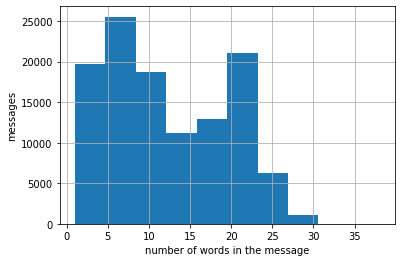

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = df[df['reviewText'].str.len()<128]['reviewText'].str.split()\
    .map(len)\
    .hist()
ax.set_xlabel("number of words in the message")
ax.set_ylabel("messages")
plt.show()

In [ ]:
len(df[df['reviewText'].str.len()<128])/len(df)

0.29048966918962055

### tokenisation

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_length_test = 128

test_sentence = 'Test tokenization sentence. Followed by another sentence'

# add special tokens
test_sentence_with_special_tokens = '[CLS]' + test_sentence + '[SEP]'
tokenized = tokenizer.tokenize(test_sentence_with_special_tokens)
print('tokenized', tokenized)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenized ['[CLS]', 'test', 'token', '##ization', 'sentence', '.', 'followed', 'by', 'another', 'sentence', '[SEP]']


In [ ]:
from pprint import pprint

# convert tokens to ids in WordPiece
input_ids = tokenizer.convert_tokens_to_ids(tokenized)
  
# precalculation of pad length, so that we can reuse it later on
padding_length = max_length_test - len(input_ids)

# map tokens to WordPiece dictionary and add pad token for those text shorter than our max length
input_ids = input_ids + ([0] * padding_length)

# attention should focus just on sequence with non padded tokens
attention_mask = [1] * len(input_ids)

# do not focus attention on padded tokens
attention_mask = attention_mask + ([0] * padding_length)

# token types, needed for example for question answering, for our purpose we will just set 0 as we have just one sequence
token_type_ids = [0] * max_length_test

bert_input = {
    "token_ids": input_ids,
    "token_type_ids": token_type_ids,
    "attention_mask": attention_mask
}

print(bert_input)

{'token_ids': [101, 3231, 19204, 3989, 6251, 1012, 2628, 2011, 2178, 6251, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
bert_input = tokenizer.encode_plus(
    test_sentence,                      
    add_special_tokens = True, # add [CLS], [SEP]
    max_length = max_length_test, # max length of the text that can go to BERT
    padding = True, # add [PAD] tokens
    truncation=True,
    return_attention_mask = True, # add attention mask to not focus on pad tokens
)

print('encoded', bert_input)

encoded {'input_ids': [101, 3231, 19204, 3989, 6251, 1012, 2628, 2011, 2178, 6251, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
import torch

labels = list(df.overall.unique())

def tok(example):
  encodings = tokenizer.encode_plus(
        example['reviewText'],                      
        add_special_tokens = True, # add [CLS], [SEP]
        max_length = max_length_test, # max length of the text that can go to BERT
        padding = True, # add [PAD] tokens
        return_attention_mask = True, # add attention mask to not focus on pad tokens
    )
  return encodings

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, random_state=42, test_size=0.3, stratify=df.overall)
print(train_df.shape, test_df.shape)

train_df, unlabeled_df = train_test_split(train_df, random_state=42, test_size=0.9, stratify=train_df.overall)
print(train_df.shape, unlabeled_df.shape, test_df.shape)

(280689, 2) (120296, 2)
(28068, 2) (252621, 2) (120296, 2)


In [ ]:
# train_df.to_csv("/content/drive/MyDrive/train_df.csv", index=False)
# train_df.to_csv("./train_df.csv", index=False)

In [ ]:
# import pandas as pd

# train_df = pd.read_csv('./train_df.csv')

In [ ]:
train_df.head()

,reviewText,overall
208223,cheap and does what it says and can be used wi...,5
314660,very cool game .\ni really like the fact you c...,4
258941,picked this up when my previous headset died. ...,4
394330,i didn't really like this one. a little confus...,2
288032,this game is amazing. everything about it. the...,5


In [ ]:
import pandas as pd
from tqdm import tqdm

def sentences_and_labels(df):
    # training data
    sentences = train_df.reviewText.values
    sentences = ["[CLS] " + sentence + " [SEP]" for sentence in tqdm(sentences)]

    # labels
    number_labels = len(train_df.overall.unique())
    labels = train_df.overall.values
    labels = pd.Series(labels)
    labels = pd.get_dummies(labels)
    labels = labels.values
    labels = labels.astype(float)

    return sentences, labels, number_labels

## Prepare data for training

In [ ]:
sentences, labels, number_labels = sentences_and_labels(train_df)

100%|██████████| 28068/28068 [00:00<00:00, 735601.88it/s]


In [ ]:
train_df.overall.unique()

array([5, 4, 2, 3, 1])

In [ ]:
print(len(sentences), len(labels))
labels[:2]

28068 28068


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [ ]:
model_type = 'bert-base-uncased'

In [ ]:
from transformers import BertTokenizer
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained(model_type, do_lower_case=True)
tokenised_text = [tokenizer.tokenize(sent) for sent in tqdm(sentences)]
print("Tokenize the first sentence")
print(tokenised_text[0])

100%|██████████| 28068/28068 [01:54<00:00, 245.60it/s]

Tokenize the first sentence
['[CLS]', 'cheap', 'and', 'does', 'what', 'it', 'says', 'and', 'can', 'be', 'used', 'with', 'sky', '##ward', 'sword', '[SEP]']


max length is 128 because it is memory failures in the training data

In [ ]:
MAX_LEN = 128

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenised_text)]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

100%|██████████| 28068/28068 [00:06<00:00, 4677.08it/s]


In [ ]:
attention_masks = []
for seq in tqdm(input_ids):
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

100%|██████████| 28068/28068 [00:03<00:00, 8890.96it/s]


In [ ]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1, stratify=labels)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

In [ ]:
import torch

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)

validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels[:2]

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]], dtype=torch.float64)

#### the batches should be balanced since the data is imbalanced.

In [ ]:
train_df.overall.value_counts()

5    15716
4     5735
3     3094
1     1957
2     1566
Name: overall, dtype: int64

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler

batch_size = 32

def create_dataloader(inputs, masks, labels, batch_size=batch_size, weights=None):
    data = TensorDataset(inputs, masks, labels)
    if weights is not None:
        sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
    else:
        sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=2)
    return dataloader

In [ ]:
counts, num_labels = train_labels.shape
class_weights = np.array([int(sum(train_labels[:, x]).detach().cpu().numpy()) for x in range(num_labels)])
# total = sum(class_weights)
# class_weights = [x/total for x in class_weights]
class_weights = 1. / class_weights
print(class_weights)
labels_unique = list(range(num_labels))

training_weights = [class_weights[int(np.argmax(e))] for e in train_labels]
print(sum(training_weights))
train_dataloader = create_dataloader(train_inputs, train_masks, train_labels, weights=training_weights)

# will not use weighted sampler for the validation weights
validation_dataloader = create_dataloader(validation_inputs, validation_masks, validation_labels)

  3%|▎         | 929/28068 [02:45<1:20:36,  5.61it/s]


[5.67859171e-04 7.09723208e-04 3.59066427e-04 1.93723363e-04
 7.07013575e-05]
5.00000000000021


### bert sequence model

In [ ]:
import transformers
from transformers import BertModel, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

configuration = BertConfig()
model = BertModel(configuration)
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(model_type, num_labels=number_labels)
if device.type != 'cpu':
    model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### overview of the different model layers

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### Differential Learning rates for Transfer Learning

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        "weight_decay_rate": 0.1
        },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        "weight_decay_rate": 0.0
        },
]


epochs = 10

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs
num_warmup_steps = int(.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

### model training

* set the number of epochs to increase or decrease the number of epochs
* printing_step controls when the training loss is printed. This is made to print 5 times per epoch here
* models are saved at the end of each epoch

In [ ]:
import random
from tqdm import tqdm, trange
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score, matthews_corrcoef

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

count = 0
t0 = datetime.utcnow()

printing_step = max(int(len(train_dataloader) / 5), 1)

t =  []
train_loss_set = []
for epoch in range(epochs):
    # training phase
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc='iteration_{}'.format(epoch))):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # print(b_labels)
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs['loss']
        train_loss_set.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        if step % printing_step == 0 and not step == 0:
            elapsed = (datetime.utcnow() - t0).total_seconds()
            print('  Batch {:>5,}  of  {:>5,} in {}. Step loss={}'.format(step, len(train_dataloader), elapsed, loss.item()))

    print(f"Train loss: {tr_loss/nb_tr_steps}")

    # validation phase
    # put the model in evaluation mode to  evaluate loss on the validation set
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = logits['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        tmp_eval_accuracy = accuracy_score(np.argmax(label_ids, axis=1), np.argmax(logits, axis=1))

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print(f"Validation accuracy: {eval_accuracy/nb_eval_steps}")

    # save the model
    model_path = '/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/transformer_model_v3'
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)

iteration_0:  20%|██        | 159/790 [03:14<12:54,  1.23s/it]

  Batch   158  of    790 in 194.769889. Step loss=0.5238966912962496


iteration_0:  40%|████      | 317/790 [06:27<09:35,  1.22s/it]

  Batch   316  of    790 in 387.849637. Step loss=0.5124313967768103


iteration_0:  60%|██████    | 475/790 [09:40<06:25,  1.22s/it]

  Batch   474  of    790 in 580.685671. Step loss=0.4754168275278062


iteration_0:  80%|████████  | 633/790 [12:53<03:11,  1.22s/it]

  Batch   632  of    790 in 773.514778. Step loss=0.42838236645329747


iteration_0: 100%|██████████| 790/790 [16:04<00:00,  1.22s/it]

Train loss: 0.49794012470052634


Validation accuracy: 0.5278687005928854


iteration_1:  20%|██        | 159/790 [03:14<12:49,  1.22s/it]

  Batch   158  of    790 in 1200.449551. Step loss=0.4034570597112179


iteration_1:  40%|████      | 317/790 [06:27<09:37,  1.22s/it]

  Batch   316  of    790 in 1393.252524. Step loss=0.3251528317399789


iteration_1:  60%|██████    | 475/790 [09:39<06:24,  1.22s/it]

  Batch   474  of    790 in 1586.068156. Step loss=0.35313628152362075


iteration_1:  80%|████████  | 633/790 [12:52<03:11,  1.22s/it]

  Batch   632  of    790 in 1778.883446. Step loss=0.29598868063185363


iteration_1: 100%|██████████| 790/790 [16:03<00:00,  1.22s/it]

Train loss: 0.33433640885644744


Validation accuracy: 0.5466897233201581


iteration_2:  20%|██        | 159/790 [03:14<12:48,  1.22s/it]

  Batch   158  of    790 in 2205.568009. Step loss=0.2710998773240135


iteration_2:  40%|████      | 317/790 [06:27<09:36,  1.22s/it]

  Batch   316  of    790 in 2398.290524. Step loss=0.19220114373893013


iteration_2:  60%|██████    | 475/790 [09:39<06:23,  1.22s/it]

  Batch   474  of    790 in 2591.144495. Step loss=0.29519522948539817


iteration_2:  80%|████████  | 633/790 [12:52<03:10,  1.21s/it]

  Batch   632  of    790 in 2783.768244. Step loss=0.20029657563281944


iteration_2: 100%|██████████| 790/790 [16:03<00:00,  1.22s/it]

Train loss: 0.23663743880244403


Validation accuracy: 0.549407114624506


iteration_3:  20%|██        | 159/790 [03:14<12:49,  1.22s/it]

  Batch   158  of    790 in 3209.964395. Step loss=0.2254301155000576


iteration_3:  40%|████      | 317/790 [06:26<09:35,  1.22s/it]

  Batch   316  of    790 in 3402.569482. Step loss=0.2535604952281574


iteration_3:  60%|██████    | 475/790 [09:40<06:23,  1.22s/it]

  Batch   474  of    790 in 3595.948231. Step loss=0.21298447160952494


iteration_3:  80%|████████  | 633/790 [12:52<03:11,  1.22s/it]

  Batch   632  of    790 in 3788.745212. Step loss=0.17339002649096075


iteration_3: 100%|██████████| 790/790 [16:04<00:00,  1.22s/it]

Train loss: 0.17468807830402253


Validation accuracy: 0.5322072628458497


iteration_4:  20%|██        | 159/790 [03:14<13:02,  1.24s/it]

  Batch   158  of    790 in 4215.61156. Step loss=0.15451227221856245


iteration_4:  40%|████      | 317/790 [06:27<09:36,  1.22s/it]

  Batch   316  of    790 in 4408.960355. Step loss=0.14797406963989487


iteration_4:  60%|██████    | 475/790 [09:40<06:29,  1.24s/it]

  Batch   474  of    790 in 4602.051256. Step loss=0.1908454582982813


iteration_4:  80%|████████  | 633/790 [12:54<03:11,  1.22s/it]

  Batch   632  of    790 in 4795.522174. Step loss=0.11252931288836408


iteration_4: 100%|██████████| 790/790 [16:05<00:00,  1.22s/it]

Train loss: 0.1384677029655857


Validation accuracy: 0.5545022233201581


iteration_5:  20%|██        | 159/790 [03:14<12:52,  1.22s/it]

  Batch   158  of    790 in 5223.710858. Step loss=0.07609164767382026


iteration_5:  40%|████      | 317/790 [06:27<09:39,  1.23s/it]

  Batch   316  of    790 in 5416.837812. Step loss=0.10649886514620449


iteration_5:  60%|██████    | 475/790 [09:40<06:25,  1.22s/it]

  Batch   474  of    790 in 5610.091736. Step loss=0.16823004636717087


iteration_5:  80%|████████  | 633/790 [12:53<03:11,  1.22s/it]

  Batch   632  of    790 in 5803.123834. Step loss=0.18261154863139384


iteration_5: 100%|██████████| 790/790 [16:05<00:00,  1.22s/it]

Train loss: 0.11270223715595198


Validation accuracy: 0.5840538537549407


iteration_6:  20%|██        | 159/790 [03:16<12:53,  1.23s/it]

  Batch   158  of    790 in 6232.560161. Step loss=0.06486255529234768


iteration_6:  40%|████      | 317/790 [06:30<09:42,  1.23s/it]

  Batch   316  of    790 in 6427.120412. Step loss=0.08215580318810681


iteration_6:  60%|██████    | 475/790 [09:45<06:27,  1.23s/it]

  Batch   474  of    790 in 6621.646271. Step loss=0.14883730538986129


iteration_6:  80%|████████  | 633/790 [12:59<03:13,  1.23s/it]

  Batch   632  of    790 in 6816.113684. Step loss=0.04637992872485484


iteration_6: 100%|██████████| 790/790 [16:12<00:00,  1.23s/it]

Train loss: 0.09576284680941537


Validation accuracy: 0.5723351037549407


iteration_7:  20%|██        | 159/790 [03:15<12:58,  1.23s/it]

  Batch   158  of    790 in 7246.072171. Step loss=0.069567841278149


iteration_7:  40%|████      | 317/790 [06:30<09:41,  1.23s/it]

  Batch   316  of    790 in 7440.612576. Step loss=0.07792617386621714


iteration_7:  60%|██████    | 475/790 [09:44<06:26,  1.23s/it]

  Batch   474  of    790 in 7635.062314. Step loss=0.12895992531630326


iteration_7:  80%|████████  | 633/790 [12:59<03:13,  1.23s/it]

  Batch   632  of    790 in 7829.4233. Step loss=0.08951869978991454


iteration_7: 100%|██████████| 790/790 [16:11<00:00,  1.23s/it]

Train loss: 0.08122577506069877


Validation accuracy: 0.5657886610671937


iteration_8:  20%|██        | 159/790 [03:15<12:57,  1.23s/it]

  Batch   158  of    790 in 8259.92495. Step loss=0.05439429563812155


iteration_8:  40%|████      | 317/790 [06:30<09:43,  1.23s/it]

  Batch   316  of    790 in 8454.324829. Step loss=0.04014271530631959


iteration_8:  60%|██████    | 475/790 [09:44<06:27,  1.23s/it]

  Batch   474  of    790 in 8648.811293. Step loss=0.0368569413514706


iteration_8:  80%|████████  | 633/790 [12:59<03:13,  1.23s/it]

  Batch   632  of    790 in 8843.181144. Step loss=0.06098329326268868


iteration_8: 100%|██████████| 790/790 [16:11<00:00,  1.23s/it]

Train loss: 0.07119019854932648


Validation accuracy: 0.5703433794466404


iteration_9:  20%|██        | 159/790 [03:16<12:54,  1.23s/it]

  Batch   158  of    790 in 9273.531418. Step loss=0.04502947696255433


iteration_9:  40%|████      | 317/790 [06:30<09:43,  1.23s/it]

  Batch   316  of    790 in 9467.942897. Step loss=0.047233229742414555


iteration_9:  60%|██████    | 475/790 [09:43<06:24,  1.22s/it]

  Batch   474  of    790 in 9661.188497. Step loss=0.08036160189531075


iteration_9:  80%|████████  | 633/790 [12:57<03:12,  1.23s/it]

  Batch   632  of    790 in 9854.595006. Step loss=0.023387677419668764


iteration_9: 100%|██████████| 790/790 [16:09<00:00,  1.23s/it]

Train loss: 0.0638997757876757


Validation accuracy: 0.5707756916996047


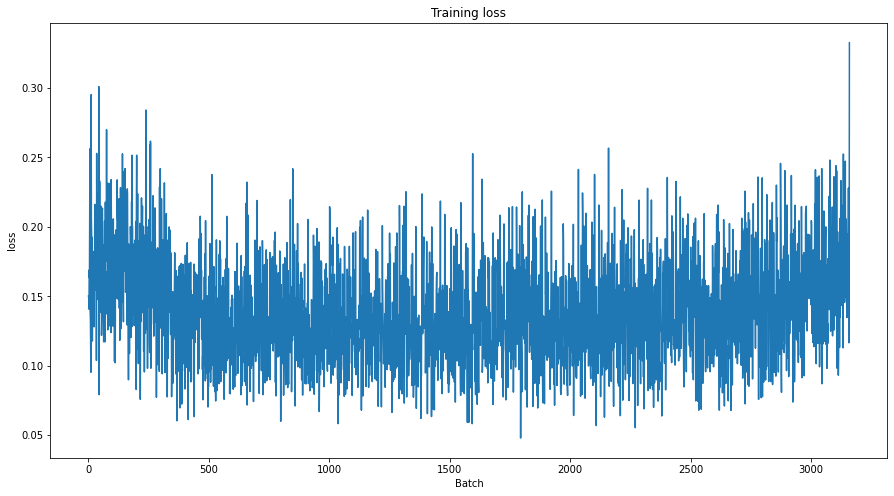

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("loss")
plt.plot(train_loss_set)
plt.show()

## save the model

In [ ]:
# model_path = '/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/transformer_model'
# model.save_pretrained(model_path)
# tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/transformer_model/tokenizer_config.json',
 '/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/transformer_model/special_tokens_map.json',
 '/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/transformer_model/vocab.txt',
 '/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/transformer_model/added_tokens.json')

## load the model

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number_labels = 5

# model_path = '/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/transformer_model'
# model_path = '/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/transformer_model_v2'
model_path = '/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/transformer_model_v3'
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=number_labels)
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=True)
if device.type != 'cpu':
    model.cuda()

In [ ]:
print(test_df.shape)
test_df.head()

(120296, 2)


,reviewText,overall
101721,the good: everything from previous gow games i...,4
334745,if you have an iphone 6 plus or a similar phab...,5
186127,amazing and has a sequel with it.,5
328955,"actually, what amazes me the most about this g...",5
153339,"the sheer, overwhelming popularity of ""assassi...",3


In [ ]:
from tqdm import tqdm
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler

sentences = test_df.reviewText.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = test_df.overall.values

tokenized_text = [tokenizer.tokenize(sent) for sent in tqdm(sentences)]

MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_text]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)


prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = RandomSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

100%|██████████| 120296/120296 [08:07<00:00, 246.78it/s]


In [ ]:
def prediction(prediction_dataloader, num_test_sents):
    print('Predicting labels for {:,} test sentences...'.format(num_test_sents))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels = [], []

    # Predict 
    for batch in tqdm(prediction_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Store predictions and true labels
        predictions.extend(logits)
        true_labels.extend(label_ids)

    return predictions, true_labels

# prediction_dataloader = create_prediction_dataloader(sentences, labels)
predictions, true_labels = prediction(prediction_dataloader, len(prediction_inputs))

Predicting labels for 120,296 test sentences...


100%|██████████| 3760/3760 [27:49<00:00,  2.25it/s]


In [ ]:
import numpy as np

predictions = np.vstack(predictions)
true_labels = np.vstack(true_labels)

test_arrays = '/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/transformer_model/test_data.npz'
np.savez(test_arrays, predictions=predictions, true_labels=true_labels)

# data = np.load('mat.npz')
# print data['name1']
# print data['name2']

In [ ]:
import numpy as np

test_arrays = '/content/drive/MyDrive/educative_natural_language_processing_for_professionals/models/transformer_model/test_data.npz'
test_arrays = np.load(test_arrays)
predictions = test_arrays['predictions']
true_labels = test_arrays['true_labels']

print(predictions.shape, true_labels.shape)

(120296, 5) (120296, 1)


In [ ]:
predictions

array([[-6.3903303 , -6.088376  , -3.4358573 , -0.4052323 ,  0.12676646],
       [-5.4610825 , -5.3867927 , -4.5617757 , -2.5009995 ,  2.3068285 ],
       [-4.8722143 , -5.2329597 , -3.987386  , -2.321256  ,  1.9564397 ],
       ...,
       [-5.7243757 , -5.960503  , -4.2150083 , -2.3468826 ,  1.9193339 ],
       [-5.221117  , -4.972651  , -0.5447195 , -0.15249604, -2.234447  ],
       [-5.233689  , -5.337388  , -4.57496   , -2.5794525 ,  2.3841028 ]],
      dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, matthews_corrcoef
from imblearn.metrics import classification_report_imbalanced

def print_classification_report(y_true, y_pred):
    y_pred_bool = np.argmax(y_pred, axis=1)
    if len(y_true.shape) == 2:
        y_true = y_true.reshape(-1) # flatten the true labels
        assert len(y_true.shape) == 1
    assert y_pred_bool.shape == y_true.shape, f'y_pred_bool.shape={y_pred_bool.shape}, y_true.shape={y_true.shape}'
    print('unique values for prediction', np.unique(y_pred_bool))
    print('unique values for true value', np.unique(y_true))
    print('accuracy:', accuracy_score(y_true, y_pred_bool + 1))
    print('matthews_corrcoef:', matthews_corrcoef(y_true, y_pred_bool + 1))
    print('classification_report:\n', classification_report_imbalanced(y_true, y_pred_bool + 1))


print_classification_report(true_labels, predictions)

unique values for prediction [0 1 2 3 4]
unique values for true value [1 2 3 4 5]
accuracy: 0.6378765711245594
matthews_corrcoef: 0.44034582401440175
classification_report:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.57      0.62      0.97      0.60      0.78      0.58      8386
          2       0.31      0.43      0.94      0.36      0.64      0.39      6711
          3       0.35      0.47      0.89      0.40      0.65      0.40     13262
          4       0.44      0.37      0.88      0.41      0.57      0.31     24579
          5       0.84      0.79      0.81      0.81      0.80      0.64     67358

avg / total       0.66      0.64      0.85      0.65      0.73      0.53    120296



In [ ]:
from sklearn.metrics import accuracy_score, matthews_corrcoef
from imblearn.metrics import classification_report_imbalanced

def print_classification_report(y_true, y_pred):
    y_pred_bool = np.argmax(y_pred, axis=1)
    if len(y_true.shape) == 2:
        y_true = y_true.reshape(-1) # flatten the true labels
        assert len(y_true.shape) == 1
    assert y_pred_bool.shape == y_true.shape, f'y_pred_bool.shape={y_pred_bool.shape}, y_true.shape={y_true.shape}'
    print('unique values for prediction', np.unique(y_pred_bool))
    print('unique values for true value', np.unique(y_true))
    print('accuracy:', accuracy_score(y_true, y_pred_bool + 1))
    print('matthews_corrcoef:', matthews_corrcoef(y_true, y_pred_bool + 1))
    print('classification_report:\n', classification_report_imbalanced(y_true, y_pred_bool + 1))


print_classification_report(true_labels, predictions)

[0 1 2 3 4]
[1 2 3 4 5]
accuracy: 0.6290400345813659
matthews_corrcoef: 0.43404486541092957
classification_report:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.61      0.63      0.97      0.62      0.78      0.59      8386
          2       0.32      0.41      0.95      0.36      0.62      0.36      6711
          3       0.37      0.42      0.91      0.40      0.62      0.37     13262
          4       0.41      0.48      0.82      0.44      0.63      0.38     24579
          5       0.85      0.75      0.83      0.79      0.79      0.61     67358

avg / total       0.66      0.63      0.85      0.64      0.73      0.52    120296



In [ ]:
 print('percentage improvement compared to the best model:', 100 * (0.564716129035763 - 0.33504969057289086) / 0.33504969057289086)

percentage improvement compared to the best model: 68.54697823184756


## Plot of model metrics till now

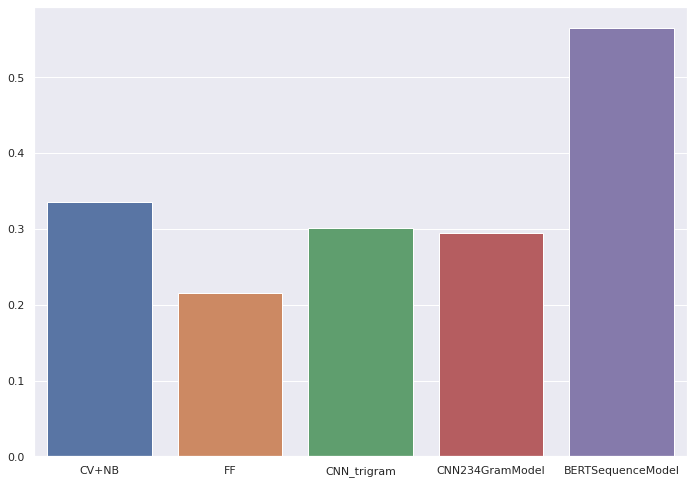

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

# data
x = ["CV+NB",             "FF",               "CNN_trigram",      "CNN234GramModel",   "BERTSequenceModel"]
y = [0.33504969057289086, 0.2148927270393169, 0.3006712012400788, 0.29459743828288504, 0.564716129035763]

ax = sns.barplot(x=x, y=y)

### single prediction

single prediction can be done using the very useful TextClassificationPipeline from huggingface.

In [ ]:
from transformers import TextClassificationPipeline

device = 0 if torch.cuda.is_available() else -1 # for the pipeline

nlp_pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=device) # device 0 for GPU

def printing_output(text, pipeline):
    print('input text: ', text)
    text = text_preprocessing(text)
    x_dict = pipeline(text)
    print('label: ', x_dict[0]['label'], 'confidence: ', x_dict[0]['score'])

printing_output('I liked the product quite a lot.', nlp_pipe)
printing_output('playing this was the worst time in my life.', nlp_pipe)

input text:  I liked the product quite a lot.
label:  LABEL_3 confidence:  0.7254188060760498
input text:  playing this was the worst time in my life.
label:  LABEL_0 confidence:  0.9827558994293213
